In [1]:
# !pip install catboost
from catboost import CatBoost

In [2]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

import catboost as catb

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

import warnings
warnings.simplefilter('ignore')

In [3]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'
train = pd.read_csv(TRAIN_DATASET_PATH) # загружаем тренировочный датасет в датафрейм df_train
test = pd.read_csv(TEST_DATASET_PATH) # загружаем тестовый датасет в датафрейм df_test

In [4]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = train.columns.drop(TARGET_NAME).tolist()

NUMB_FEATURE_NAMES = ['Annual Income','Tax Liens','Number of Open Accounts','Years of Credit History',
                     'Maximum Open Credit','Number of Credit Problems','Months since last delinquent',
                     'Bankruptcies','Current Loan Amount','Current Credit Balance','Monthly Debt','Credit Score']

CAT_FEATURE_NAMES = ['Years in current job','Home Ownership','Purpose','Term']

In [5]:
train.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
5,Rent,NaN,7 years,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0
7,Rent,1040060.0,10+ years,0.0,13.0,12.0,330374.0,0.0,18.0,0.0,other,Short Term,250888.0,89015.0,19761.0,705.0,1
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
9,Home Mortgage,NaN,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1


Распределение значений целевой переменной

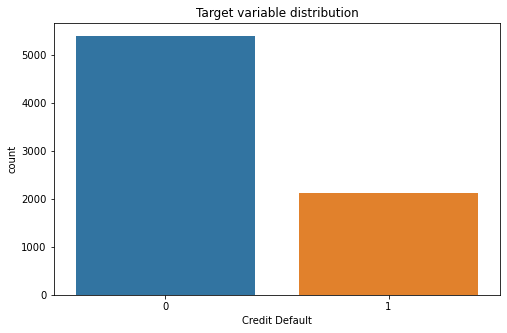

In [6]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=train)

plt.title('Target variable distribution')
plt.show()

In [7]:
plt.figure(figsize = (15,10))

sns.set(font_scale=0.8)

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
corr_matrix = train.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix,mask=mask,  annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

NameError: name 'corr' is not defined

<Figure size 1080x720 with 0 Axes>

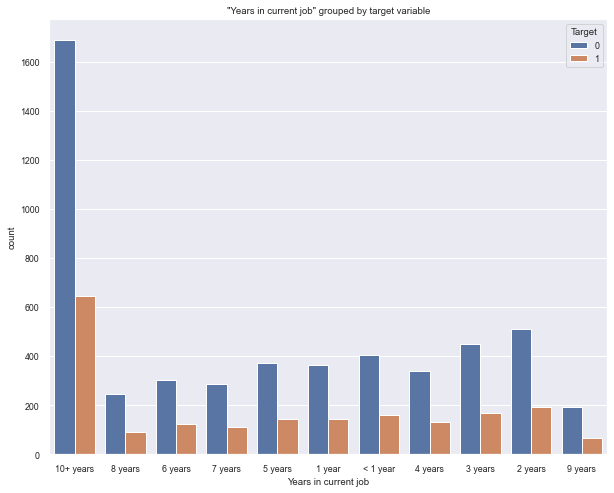

In [8]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Years in current job", hue=TARGET_NAME, data=train)
plt.title('\"Years in current job\" grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

Исследование пропусков и заполнение пропусков

In [9]:
train.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [10]:
class FeatureCorrector:
    
    def __init__(self):
        
        self.maximum_open_credit_max = None
        self.current_loan_amount_max = None
        self.medians = None
        self.year_mode = None
        self.mask_year = None
        self.mask_deliq = None
        self.mask_term = None
        
    def fit(self, df):
        
        self.max_open_credit_max = df['Maximum Open Credit'].quantile(0.85)
        self.cur_loan_amount_max = 800000 #df['Current Loan Amount'].quantile(0.9)
        self.medians = df.median()
        self.year_mode = df['Years in current job'].mode().astype(str)[0]
        self.mask_deliq = {True : 0, False: 1}
        self.mask_term = {'Short Term': 0, 'Long Term': 1}
        
        
    def transform(self, df):
        
        # Annual Income
        
        df['Annual_Income_is_NaN'] = 0
        df.loc[df['Annual Income'].isnull() == True, 'Annual_Income_is_NaN'] = 1
        
        df['Annual Income'].fillna(self.medians['Annual Income'], inplace=True)
        
        # Years in current job
        
        df['Years in current job'] = df['Years in current job'].fillna(self.year_mode)
        
        # Home Ownership
        
        df.loc[train["Home Ownership"] == "Have Mortgage", "Home Ownership"] = "Home Mortgage"
        
        # Tax Liens
        
        df.loc[df['Tax Liens'] > 0, 'Tax Liens'] = 1
        
        # Months since last delinquent
        
        df['Months since last delinquent'] = df['Months since last delinquent'].isna().map(self.mask_deliq)
        
        # Bankruptcies
        
        df["Bankruptcies"].fillna(0, inplace=True)
        
        # Term
        
        df['Term'] = df['Term'].map(self.mask_term)
        
        # Current Loan Amount
        
        df.loc[df['Current Loan Amount'] > self.cur_loan_amount_max , 'Current Loan Amount'] = self.cur_loan_amount_max
        df['Current Loan Amount'].fillna(self.medians['Current Loan Amount'])
        
        # Maximum Open Credit
        
        df.loc[df['Maximum Open Credit'] > self.max_open_credit_max, 'Maximum Open Credit'] = self.max_open_credit_max
        
        # Credit Score
        
        df.loc[df['Credit Score'] > 1000, 'Credit Score'] = df['Credit Score'] / 10
        df['Credit Score'].fillna(self.medians['Credit Score'], inplace=True)
        
        # convert to int64
        
        df['Tax Liens'] = df['Tax Liens'].astype('int64')
        df['Bankruptcies'] = df['Bankruptcies'].astype('int64')
        df['Number of Credit Problems'] = df['Number of Credit Problems'].astype('int64')
        
        return df

In [11]:
corrector = FeatureCorrector()

corrector.fit(train)

train = corrector.transform(train)
test = corrector.transform(test)

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7500 non-null   object 
 3   Tax Liens                     7500 non-null   int64  
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   int64  
 8   Months since last delinquent  7500 non-null   int64  
 9   Bankruptcies                  7500 non-null   int64  
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   int64  
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [13]:
train.isna().sum().sum()

0

In [14]:
test.isna().sum().sum()

0

Вспомогательные функции

In [15]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [16]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)

Корреляция признаков

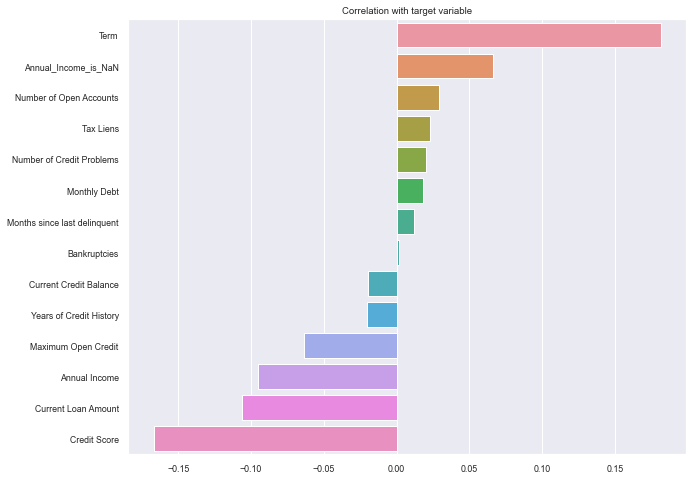

In [17]:
NEW_FEATURE_NAMES = ['Annual_Income_is_NaN']

corr_with_target = train[BASE_FEATURE_NAMES + 
                            NEW_FEATURE_NAMES +
                            [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

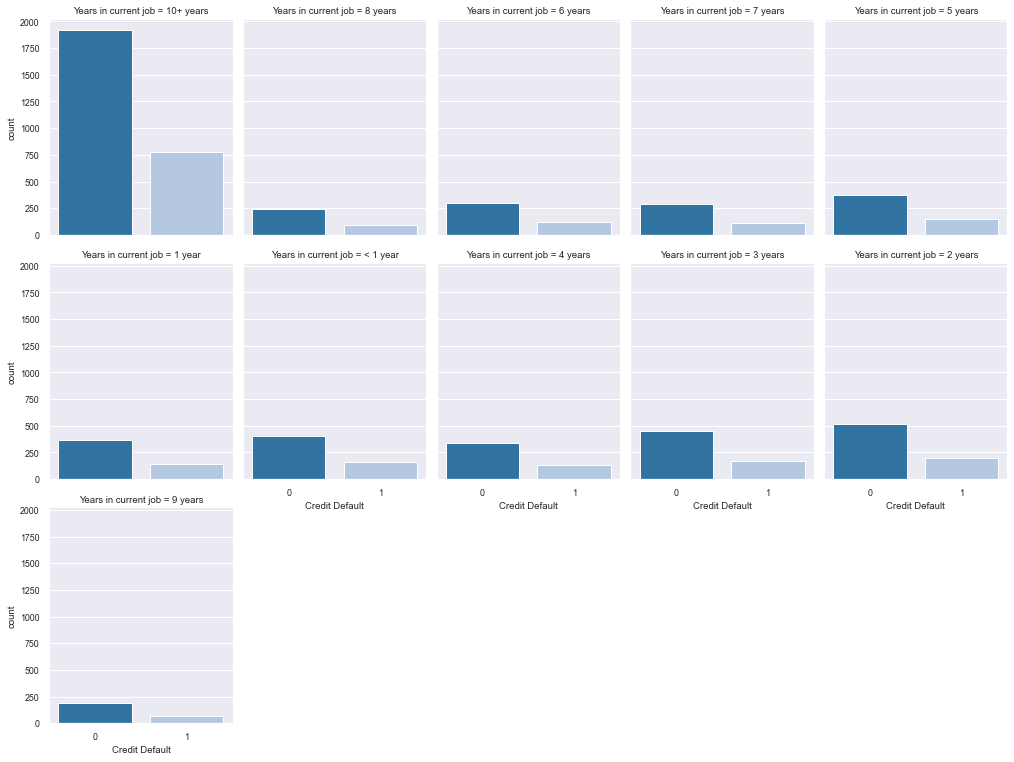

In [18]:
# Количество людей, разделенных по стажу, которые возращают и не возвращают кредит

g = sns.catplot("Credit Default", col="Years in current job", col_wrap=5,
                data=train,
                kind="count", height=3.5, aspect=.8, 
                palette='tab20')

plt.show()

Разделение тренировочного датасета

In [19]:
X = train[BASE_FEATURE_NAMES]
y = train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=11)

Учет дисбаланса классов в модели

In [20]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

2.54251012145749

In [21]:
# выбор пал на catboost, потому что методом подбора моделей, учитывая категориальные признаки, лучше всего себя показывает
# потому что по дефолту имеет огромный спектр по подбору гиперпараметров
# я не приводил других моделей, потому что они себя не очень стабильно вели, опираясь на мою чистку данных

model_catb = catb.CatBoostClassifier(class_weights=[1, disbalance], silent=True, random_state=11, cat_features=CAT_FEATURE_NAMES)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.94      0.78      0.85      3768
           1       0.60      0.87      0.71      1482

    accuracy                           0.80      5250
   macro avg       0.77      0.82      0.78      5250
weighted avg       0.84      0.80      0.81      5250

TEST

              precision    recall  f1-score   support

           0       0.82      0.67      0.74      1619
           1       0.42      0.62      0.50       631

    accuracy                           0.65      2250
   macro avg       0.62      0.64      0.62      2250
weighted avg       0.71      0.65      0.67      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1083  536
1                241  390


Подбор оптимальных параметров модели

In [22]:
model_catb = catb.CatBoostClassifier(class_weights=[1, disbalance], silent=True, random_state=11, cat_features=CAT_FEATURE_NAMES)

In [23]:
params = {'n_estimators':[100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth':[3, 5, 7]}

In [24]:
cv=KFold(n_splits=5, random_state=11, shuffle=True)

In [25]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

Wall time: 7min 41s


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=11, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x000001DA84C86F08>,
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 7],
                                        'n_estimators': [100, 200, 500, 700,
                                                         1000, 1200, 1500]},
                   scoring='f1')

In [26]:
rs.best_params_

{'n_estimators': 1500, 'max_depth': 3}

In [27]:
rs.best_score_

0.5123296099029215

Итоговая модель

In [28]:
%%time
# поэкспериментировав с полученными параметрами, лучшими были 700 и 3



final_model = catb.CatBoostClassifier(n_estimators=700, max_depth=3,
                                      class_weights=[1, disbalance],
                                      eval_metric='F1',
                                      cat_features=CAT_FEATURE_NAMES,
                                      silent=True, random_state=11)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.65      0.75      3768
           1       0.47      0.78      0.58      1482

    accuracy                           0.68      5250
   macro avg       0.67      0.71      0.66      5250
weighted avg       0.76      0.68      0.70      5250

TEST

              precision    recall  f1-score   support

           0       0.84      0.59      0.70      1619
           1       0.41      0.72      0.52       631

    accuracy                           0.63      2250
   macro avg       0.62      0.65      0.61      2250
weighted avg       0.72      0.63      0.65      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               960  659
1               179  452
Wall time: 8.01 s


Предсказание на тестовой выборке

In [29]:
df_model = test[BASE_FEATURE_NAMES]

y_pred = final_model.predict(df_model)

preds_final = pd.DataFrame()
preds_final = pd.DataFrame({'Id': np.arange(0,y_pred.shape[0]), 'Credit Default': y_pred})
preds_final

,Id,Credit Default
0,0,1
1,1,1
2,2,0
3,3,0
4,4,0
...,...,...
2495,2495,0
2496,2496,1
2497,2497,1
2498,2498,0


In [30]:
preds_final.to_csv('./Credit_default_prediction4.csv', index=False, encoding='utf-8', sep=',')